In [1]:
"""
    This notebook is used to generate the figures for the following section:
    "Dataset Generation"
"""

'\n    This notebook is used to generate the figures for the following section:\n    "Dataset Generation"\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from stg import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from stg import DICs

# seed
np.random.seed(0)


In [3]:
from utils import latin_hyper_cube_sampling

g_s_range = [-20, 20]
g_u_range = [0, 20]

N_train = 1000000//16
N_val = 200000//16

print("N_train: ", N_train)
print("N_val: ", N_val)

train_DICs = latin_hyper_cube_sampling(N_train, 2, [g_s_range, g_u_range])
val_DICs = latin_hyper_cube_sampling(N_val, 2, [g_s_range, g_u_range])
train_DICs = pd.DataFrame(train_DICs, columns=["g_s", "g_u"])
val_DICs = pd.DataFrame(val_DICs, columns=["g_s", "g_u"])

train_DICs["label"] = "train"
val_DICs["label"] = "val"

dataset = pd.concat([train_DICs, val_DICs], axis=0)
dataset["g_s"] = dataset["g_s"].astype(np.float32)
dataset["g_u"] = dataset["g_u"].astype(np.float32)

N_train:  62500
N_val:  12500


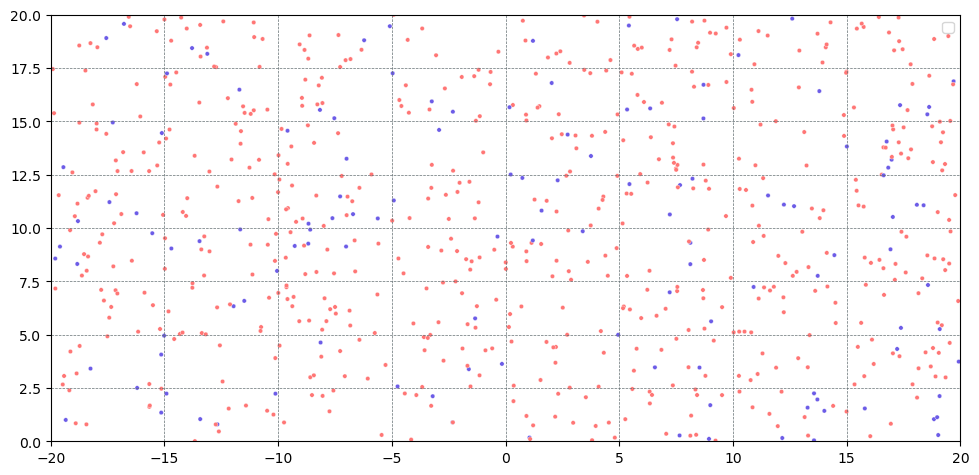

In [4]:
# == plot the dataset as a scatter plot, hue by label ==
train_color = "#ff7675"
val_color = "#6c5ce7"
frac = 0.01
samp = dataset.sample(frac=frac, random_state=42)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=samp, x="g_s", y="g_u", hue="label", alpha=1, s=10, palette=[train_color, val_color])
plt.tight_layout()
plt.legend("")
plt.xlabel("")
plt.ylabel("")
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=1, color='#636e72')
plt.xlim(-20, 20)
plt.ylim(0, 20)
#save as svg
plt.savefig("figures/dics_grid.svg", dpi=300)
plt.show()

# approximate value that are in the sets such that we can make a nice plot
g_s_val = -10.
g_u_val = 2.5

g_s_train = 5.
g_u_train = 10.

In [5]:
M = 4
from stg import generate_neuromodulated_population
val_pop = generate_neuromodulated_population(M, -51., g_s_target=g_s_val, g_u_target=g_u_val)
train_pop = generate_neuromodulated_population(M, -51., g_s_target=g_s_train, g_u_target=g_u_train)

print("val_pop: ", val_pop.shape)
print("train_pop: ", train_pop.shape)

from utils import simulate_population_t_eval_multiprocessing
# Wrapper to simulate the population using multiprocessing
def simulate_population(population, U0 = get_default_u0(), T_EVAL = np.arange(3000, 5000, 0.05), PARAMS=get_default_parameters(), MAX_WORKERS=16):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return np.asarray(simulate_population_t_eval_multiprocessing(simulate_individual_t_eval, population, U0, T_EVAL, PARAMS, MAX_WORKERS, verbose=True))[:, 1, :]
    
# Simulate the populations
train_pop_sim = simulate_population(train_pop)
val_pop_sim = simulate_population(val_pop)

print("train_pop_sim: ", train_pop_sim.shape)
print("val_pop_sim: ", val_pop_sim.shape)

val_pop:  (4, 8)
train_pop:  (4, 8)


Simulating population (multiprocessing): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

train_pop_sim:  (4, 40000)
val_pop_sim:  (4, 40000)


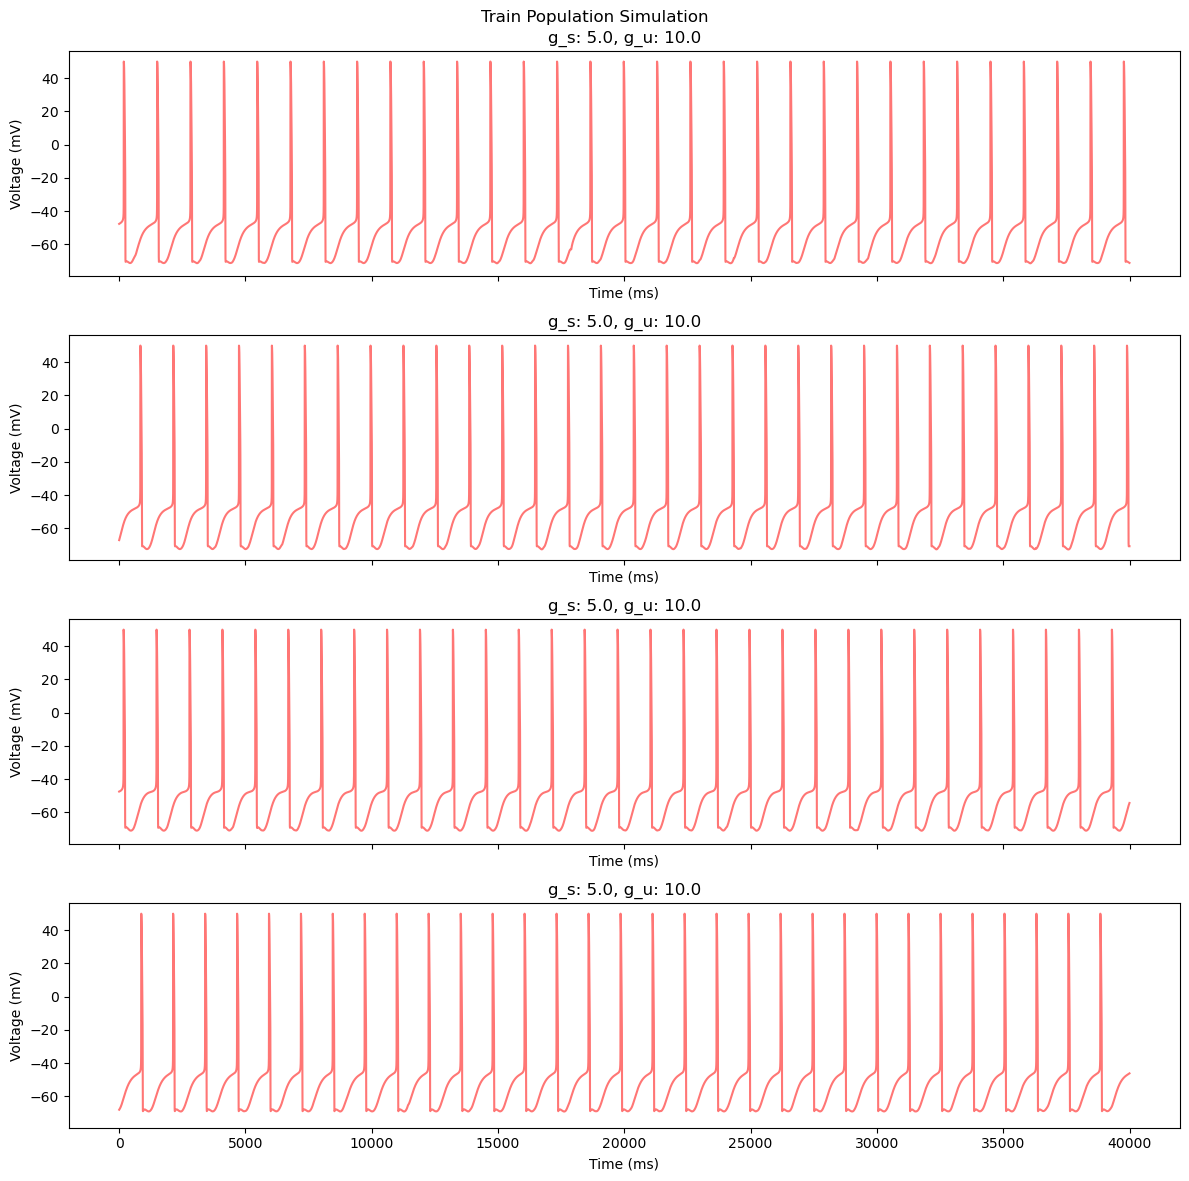

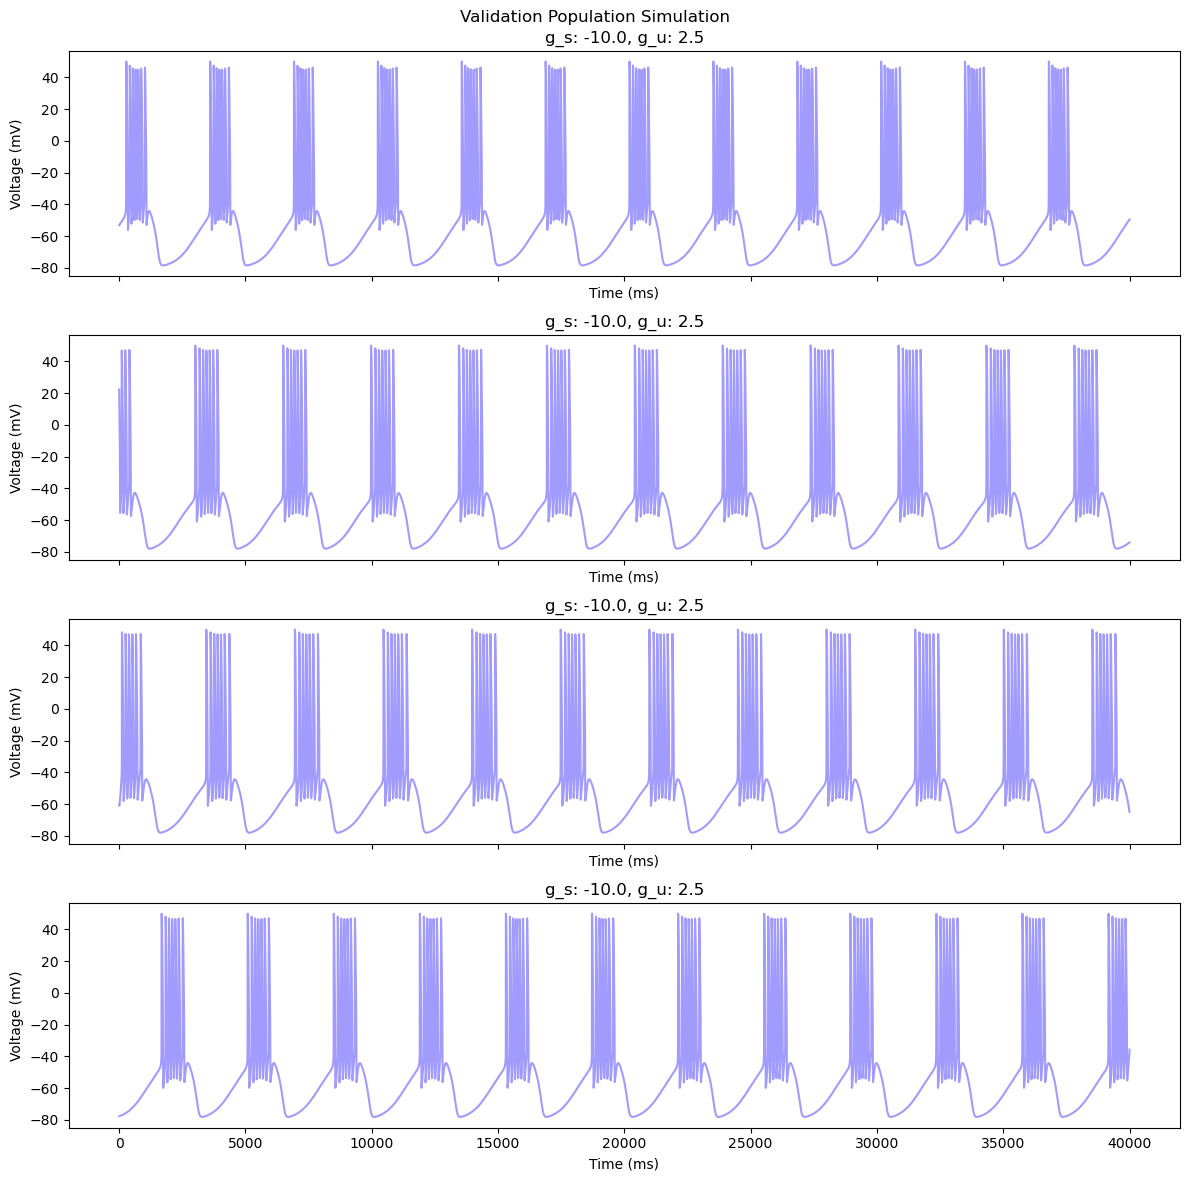

In [6]:
# train
val_color = "#a29bfe"
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)
for i in range(4):
    axs[i].plot(train_pop_sim[i, :], color=train_color)
    axs[i].set_title(f"g_s: {g_s_train}, g_u: {g_u_train}")
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Voltage (mV)")

plt.suptitle("Train Population Simulation")
plt.tight_layout()
# save as svg
plt.savefig("figures/train_population_simulation.svg", dpi=300)
plt.show()

# val
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)
for i in range(4):
    axs[i].plot(val_pop_sim[i, :], color=val_color)
    axs[i].set_title(f"g_s: {g_s_val}, g_u: {g_u_val}")
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Voltage (mV)")

plt.suptitle("Validation Population Simulation")
plt.tight_layout()
# save as svg
plt.savefig("figures/val_population_simulation.svg", dpi=300)
plt.show()


In [7]:
# == load the dataset ==

# Load the dataset
dataset_path = "tmp/training_set_stg.csv"

from inference import SpikeFeatureExtractor

sfe = SpikeFeatureExtractor(model='stg')

result = sfe.extract_from_csv(dataset_path,num_workers=16, verbose=True)

dataset = pd.read_csv(dataset_path)


#combine back the g_s and g_u
result["g_s"] = dataset["g_s"].astype(np.float32)
result["g_u"] = dataset["g_u"].astype(np.float32)

# remove nan
result = result.dropna()

del dataset

Loading data from tmp/training_set_stg.csv
Data loaded, number of samples: 1199999
Preprocessing data
Data preprocessed, extracting features
Extracting features from 1199999 samples using 16 workers


100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


min, max, mean and median of the len column (excluding label 0):
min: 3
max: 176
mean: 50.48878440190716
median: 37.0
No save path provided, returning the results.


Spiking:  0.516691681675672
Bursting:  0.48095107064238546
Silent:  0.002357247681942499


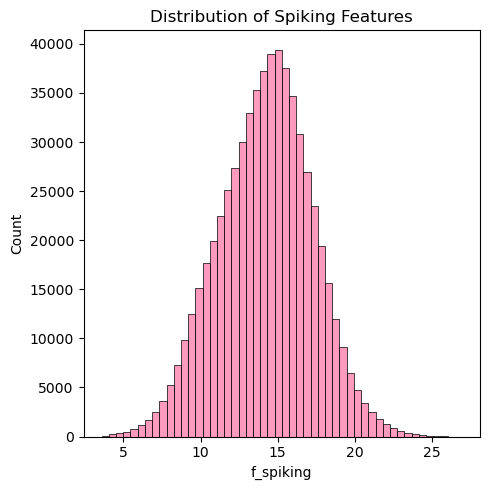

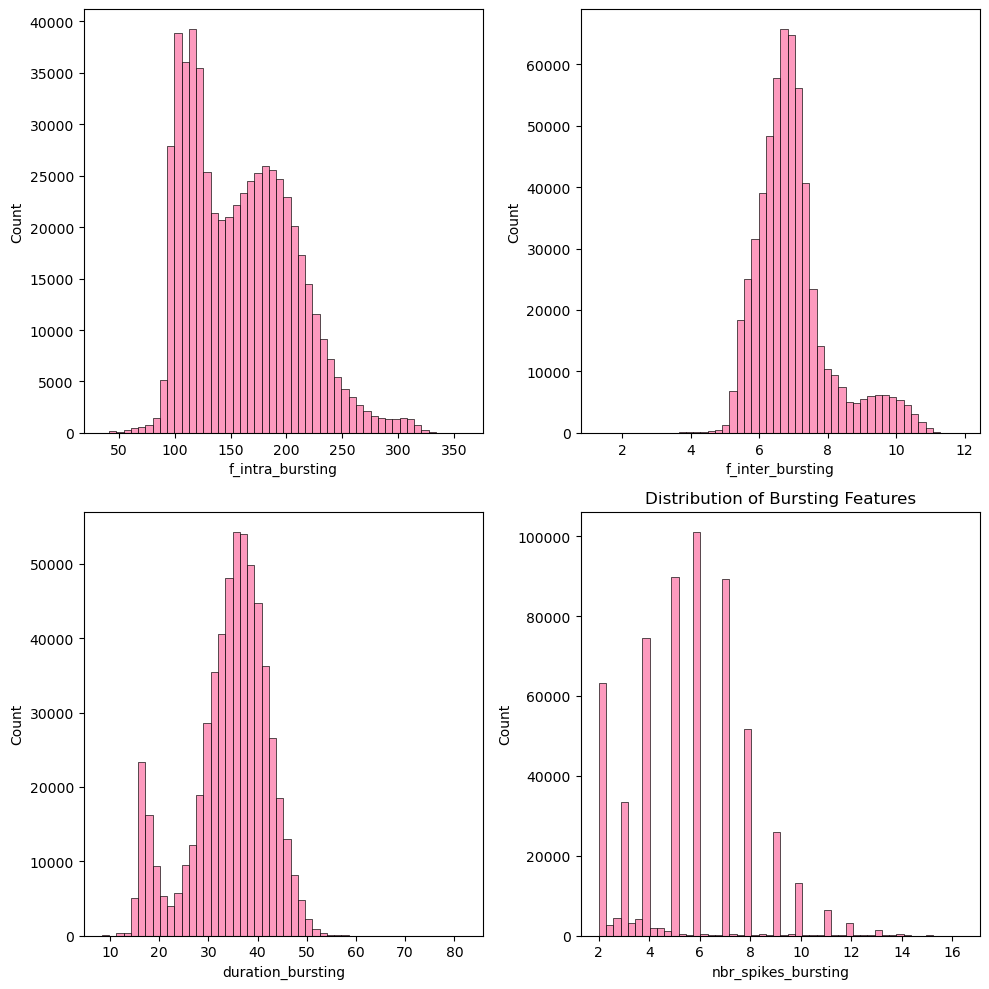

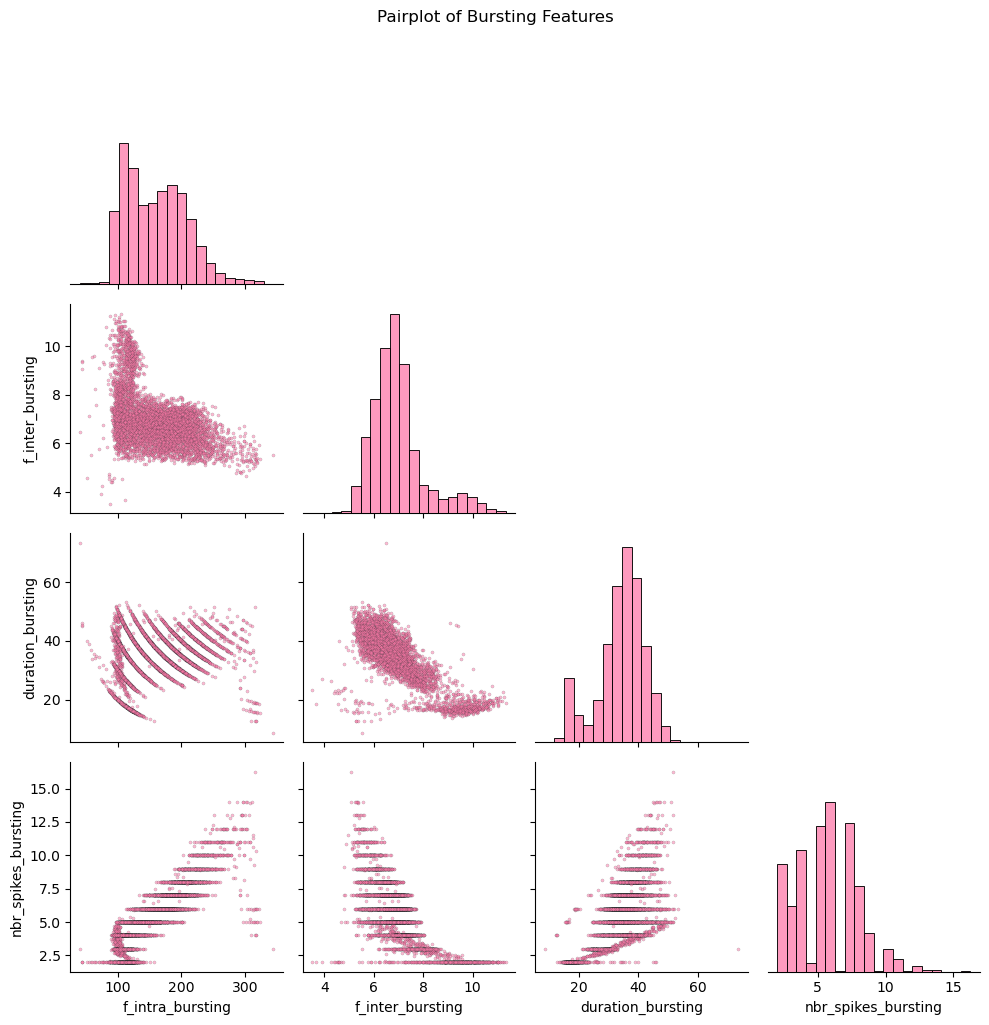

Spiking Features std:  f_spiking    3.036116
dtype: float64
Bursting Features std:  f_intra_bursting       47.584497
f_inter_bursting        1.099900
duration_bursting       7.827177
nbr_spikes_bursting     2.240907
dtype: float64


In [8]:
color = "#fd79a8"
edge_color = "#2d3436"

bins=50

#using the 'label' column
spiking_results = result[result['label'] == 1]
bursting_results = result[result['label'] == 2]
silent_results = result[result['label'] == 0]
#print percentage of each class
print("Spiking: ", len(spiking_results)/len(result))
print("Bursting: ", len(bursting_results)/len(result))
print("Silent: ", len(silent_results)/len(result))

# clean the bursting : remove duration_bursting > 200
bursting_results = bursting_results[bursting_results['duration_bursting'] <90]

# distribution of features :'f_spiking', 'f_intra_bursting','f_inter_bursting', 'duration_bursting', 'nbr_spikes_bursting'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data=spiking_results, x='f_spiking',bins=bins, ax=ax, color=color)
plt.title("Distribution of Spiking Features")
plt.xlabel("f_spiking")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/spiking_features_distribution.svg", dpi=300)
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=bursting_results, x='f_intra_bursting', bins=bins, ax=ax[0, 0], color=color)
sns.histplot(data=bursting_results, x='f_inter_bursting', bins=bins, ax=ax[0, 1], color=color)
sns.histplot(data=bursting_results, x='duration_bursting', bins=bins, ax=ax[1, 0], color=color)
sns.histplot(data=bursting_results, x='nbr_spikes_bursting', bins=bins, ax=ax[1, 1], color=color)
plt.title("Distribution of Bursting Features")
ax[0, 0].set_xlabel("f_intra_bursting")
ax[0, 1].set_xlabel("f_inter_bursting")
ax[1, 0].set_xlabel("duration_bursting")
ax[1, 1].set_xlabel("nbr_spikes_bursting")
plt.tight_layout()
plt.savefig("figures/bursting_features_distribution.svg", dpi=300)
plt.show()

frac = 0.01
# pairplot of the bursting features
sns.pairplot(
    bursting_results[['f_intra_bursting', 'f_inter_bursting', 'duration_bursting', 'nbr_spikes_bursting']].sample(frac=frac),
    diag_kind='hist',
    corner=True,
    plot_kws={'s': 5, 'alpha': 0.5, 'edgecolor': edge_color, 'color': color},
    diag_kws={'bins': 20, 'color': color},
    #scattercolor
)
plt.suptitle("Pairplot of Bursting Features", y=1.02)
plt.tight_layout()
plt.savefig("figures/bursting_features_pairplot.svg", dpi=300)
plt.show()

# print the std of the features
print("Spiking Features std: ", spiking_results[['f_spiking']].std())
print("Bursting Features std: ", bursting_results[['f_intra_bursting', 'f_inter_bursting', 'duration_bursting', 'nbr_spikes_bursting']].std())
# print the mean of the features


/tmp/ipykernel_25839/3944835575.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  homogeneity_mean = homogeneity.groupby(['g_s_bin', 'g_u_bin'])['entropy'].mean().reset_index()


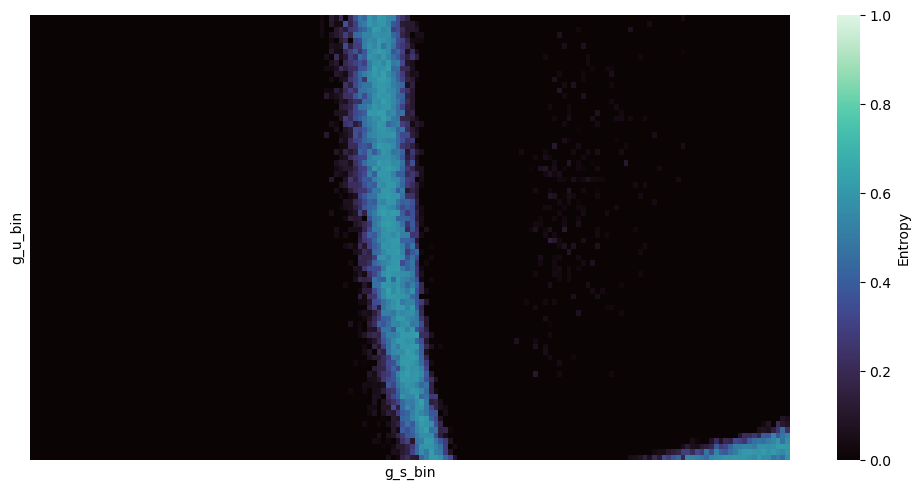

Entropy:  0.999999999726928


In [9]:
# we measure 'homogeneity' of the population : that is, for a same (g_s, g_u), are the labels similar ?
# we group by g_s and g_u and count the number of individu with label = 0, label = 1 and label = 2; 
# we compute the entropy of the distribution of labels
# we plot the entropy as a function of g_s and g_u

def compute_entropy(x):
    """
    Compute the entropy of a distribution
    :param x: distribution
    :return: entropy
    """
    p = x / np.sum(x)
    h = -np.sum(p * np.log(p + 1e-10))

    # normalize the entropy by log(k)
    # where k is the number of classes
    k = len(x)
    h = h / np.log(k)

    return h

def compute_homogeneity(df):
    """
    Compute the homogeneity of the population
    :param df: dataframe
    :return: dataframe with g_s, g_u and entropy
    """
    # group by g_s and g_u and count the number of individu with label = 0, label = 1 and label = 2
    grouped = df.groupby(['g_s', 'g_u', 'label']).size().unstack(fill_value=0)
    # compute the entropy of the distribution of labels
    grouped['entropy'] = grouped.apply(compute_entropy, axis=1)
    # reset index
    grouped.reset_index(inplace=True)
    return grouped

# compute the homogeneity of the population
homogeneity = compute_homogeneity(result.sample(frac=1))

# we bin:
s = 4
g_s_bin = 40 * s
g_u_bin = 20 * s
homogeneity['g_s_bin'] = pd.cut(homogeneity['g_s'], g_s_bin)
homogeneity['g_u_bin'] = pd.cut(homogeneity['g_u'], g_u_bin)
# compute the mean entropy for each bin
homogeneity_mean = homogeneity.groupby(['g_s_bin', 'g_u_bin'])['entropy'].mean().reset_index()
# plot the mean entropy as a function of g_s and g_u
from scipy.ndimage import generic_filter

# First, create the pivoted DataFrame as before
df_pivoted = homogeneity_mean.pivot(index='g_u_bin', columns='g_s_bin', values='entropy')

# Convert to numpy array for easier processing
arr = df_pivoted.to_numpy()

# Define a function to compute the mean of non-NaN neighbors
def nanmean_filter(values):
    values = values[~np.isnan(values)]  # Remove NaNs
    return np.mean(values) if len(values) > 0 else np.nan

# Apply the filter (footprint=3x3 neighborhood)
filled_arr = arr.copy()
mask = np.isnan(filled_arr)
filled_arr[mask] = generic_filter(filled_arr, nanmean_filter, size=3, mode='constant', cval=np.nan)[mask]

# Create a new DataFrame with the filled values
df_filled = pd.DataFrame(filled_arr, index=df_pivoted.index, columns=df_pivoted.columns)

plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    df_filled,
    cmap='mako',
    cbar_kws={'label': 'Entropy'},
    vmin=0, vmax=1,
    square=False,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)
ax.collections[0].set_rasterized(True)
ax.invert_yaxis()
#no labels on the axes
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tight_layout()
# save as svg
plt.savefig("figures/dataset_homogeneity.svg", dpi=300)
plt.show()

p = [1000, 1000, 1000]
p = np.array(p)
h = compute_entropy(p)
print("Entropy: ", h) # ok uniform is 1

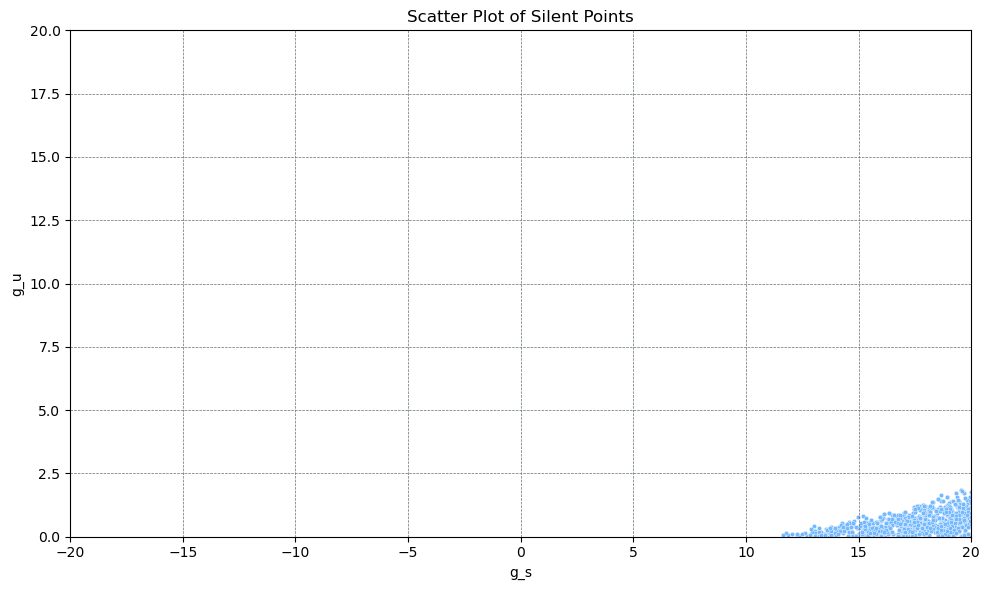

In [10]:
# scatter the point with label = 0 in the (-20, 20) x (0,20) space

silent_results_sample = silent_results.sample(frac=1, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=silent_results_sample, x="g_s", y="g_u", alpha=1, s=10, color="#74b9ff")
plt.title("Scatter Plot of Silent Points")
plt.xlabel("g_s")
plt.ylabel("g_u")
plt.xlim(-20, 20)
plt.ylim(0, 20)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=1, color='#636e72')
plt.tight_layout()
plt.savefig("figures/silent_points_scatter.svg", dpi=300)
plt.show()

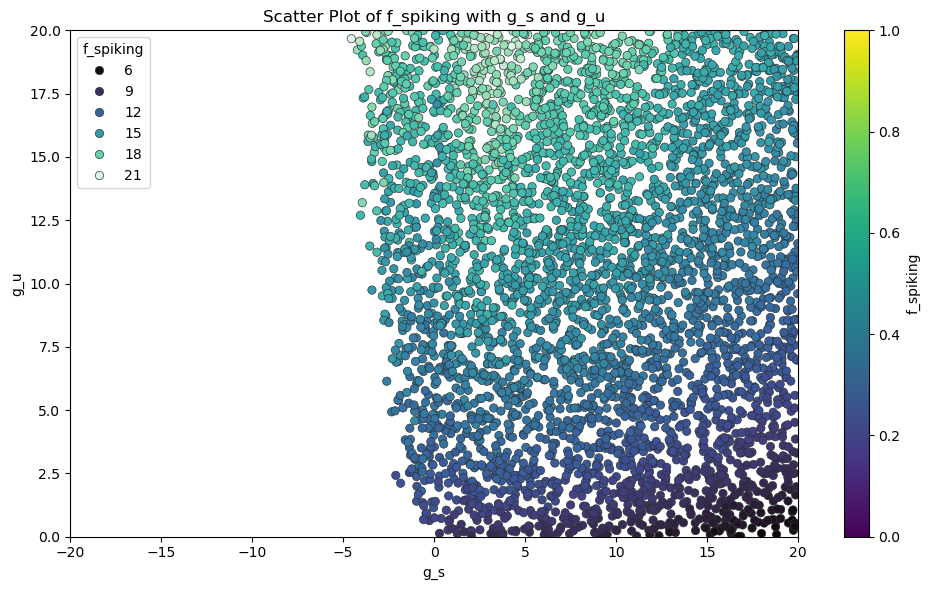

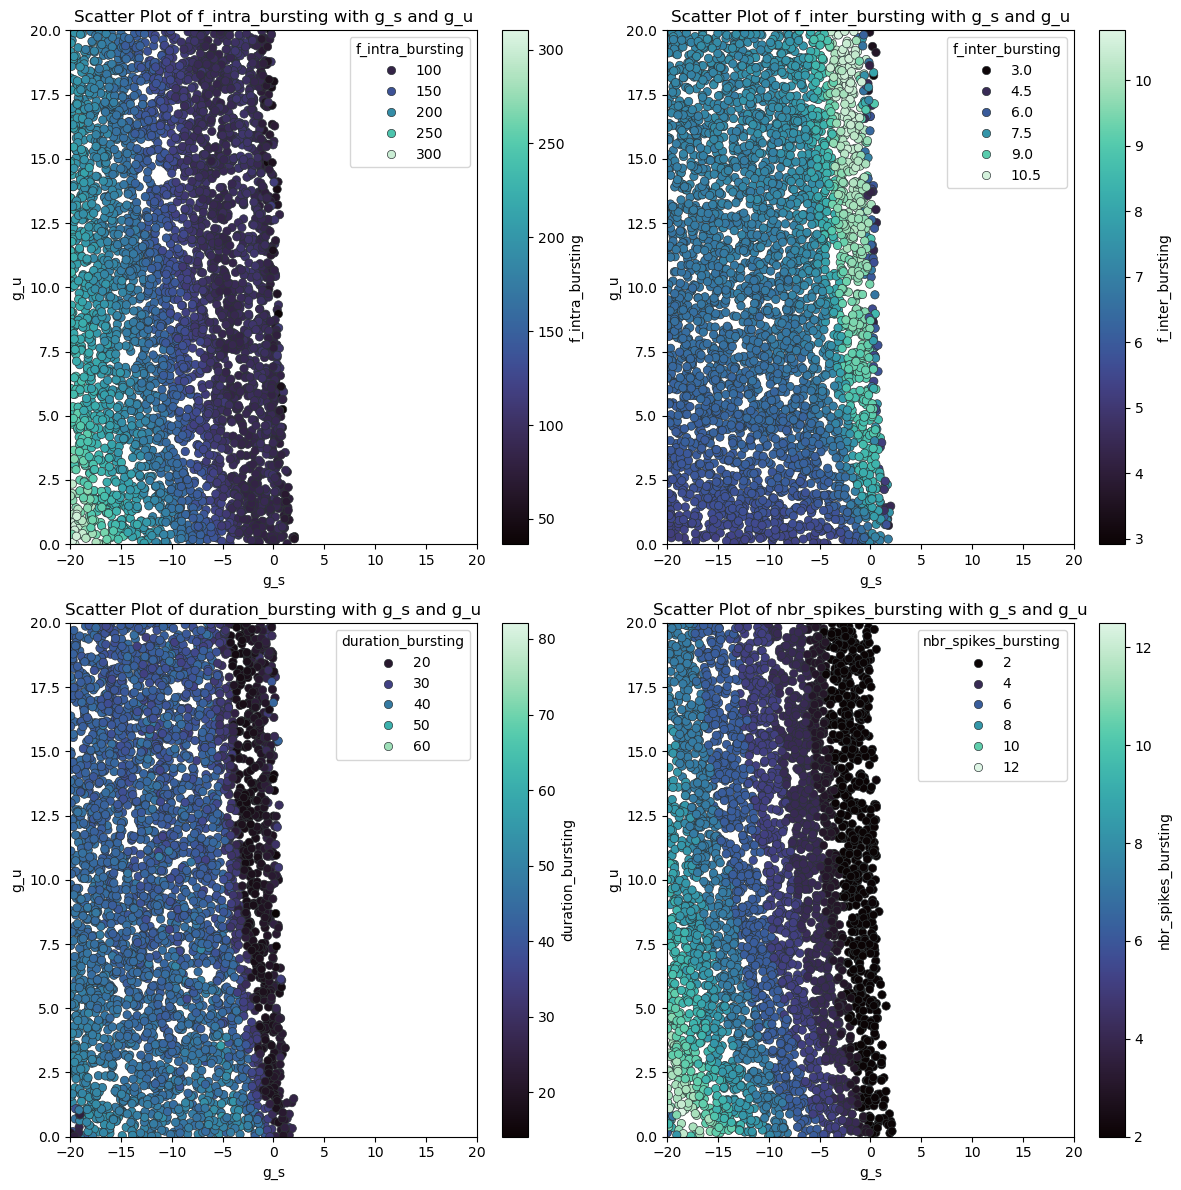

In [11]:
# == RELATION BETWEEN THE FEATURES AND g_s, g_u ==
# group features by g_s and g_u (using median)
features = ['f_spiking', 'f_intra_bursting', 'f_inter_bursting', 'duration_bursting', 'nbr_spikes_bursting']
dspiking_results = result[result['label'] == 1]
bursting_results = result[result['label'] == 2]

# group 
dspiking_results = dspiking_results.groupby(['g_s', 'g_u'])[features].median().reset_index()
bursting_results = bursting_results.groupby(['g_s', 'g_u'])[features].median().reset_index()

# remove any g_s > 4 from the bursting results for visual clarity
bursting_results = bursting_results[bursting_results['g_s'] < 4]

frac = 0.1

# == scatter plot of the features with g_s and g_u ==

# spiking (only f_spiking)
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=dspiking_results.sample(frac=frac),
    x="g_s",
    y="g_u",
    hue="f_spiking",
    palette="mako",
    alpha=1,
    edgecolor=edge_color,
)
plt.colorbar(scatter.collections[0], label="f_spiking")
plt.title("Scatter Plot of f_spiking with g_s and g_u")
plt.xlabel("g_s")
plt.ylabel("g_u")
plt.xlim(-20, 20)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

# bursting (all except f_spiking)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
bursting_features = ['f_intra_bursting', 'f_inter_bursting', 'duration_bursting', 'nbr_spikes_bursting']

for i, feature in enumerate(bursting_features):
    ax = axs[i // 2, i % 2]
    vmin = bursting_results[feature].min()
    vmax = bursting_results[feature].max()
    scatter = sns.scatterplot(
        data=bursting_results.sample(frac=frac),
        x="g_s",
        y="g_u",
        hue=feature,
        palette="mako",
        alpha=1,
        edgecolor=edge_color,
        ax=ax,
    )
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=feature)
    ax.set_title(f"Scatter Plot of {feature} with g_s and g_u")
    ax.set_xlabel("g_s")
    ax.set_ylabel("g_u")
    ax.set_xlim(-20, 20)
    ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()

/tmp/ipykernel_25839/4249007539.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_spiking_results_mean = binned_spiking_results.groupby(['g_s_bin', 'g_u_bin'])[features].mean().reset_index()
/tmp/ipykernel_25839/4249007539.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_bursting_results_mean = binned_bursting_results.groupby(['g_s_bin', 'g_u_bin'])[bursting_features].mean().reset_index()


vmin: 4.921035130818685, vmax: 20.976633071899414


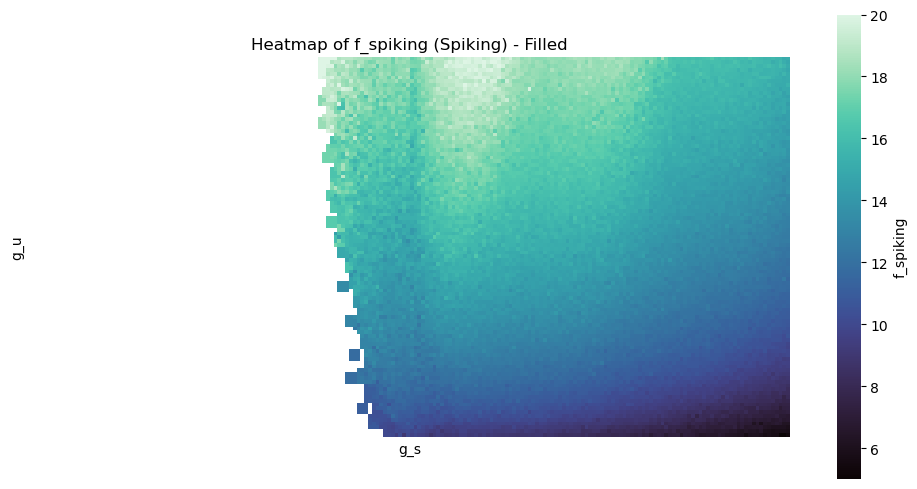

vmin: 39.501651763916016, vmax: 310.2578430175781


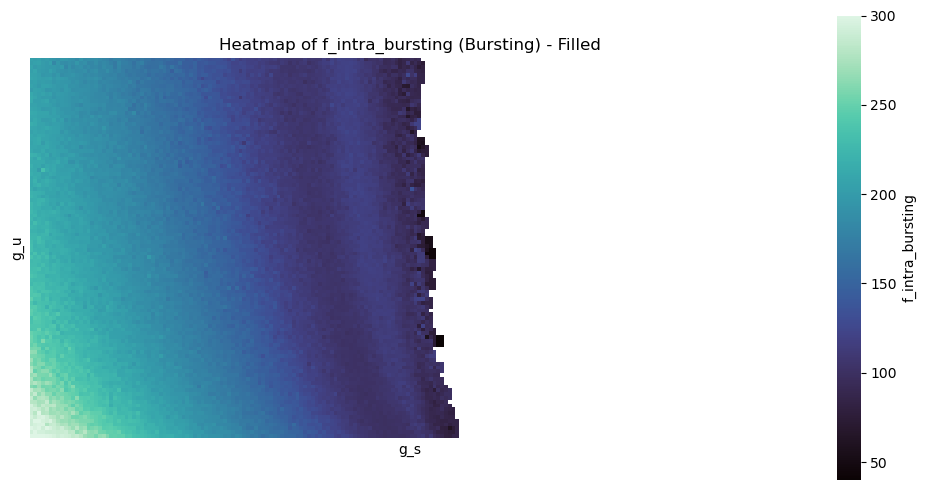

vmin: 2.9446399211883545, vmax: 10.654356956481934


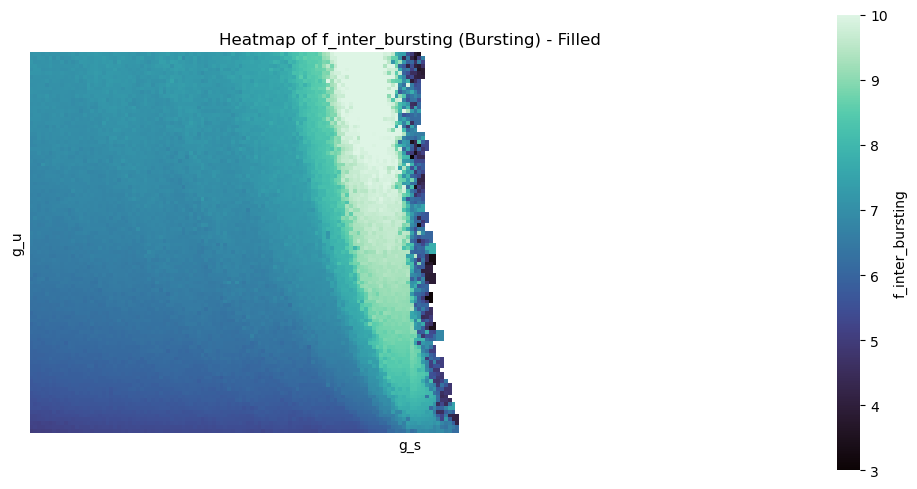

vmin: 14.669995307922363, vmax: 51.05912780761719


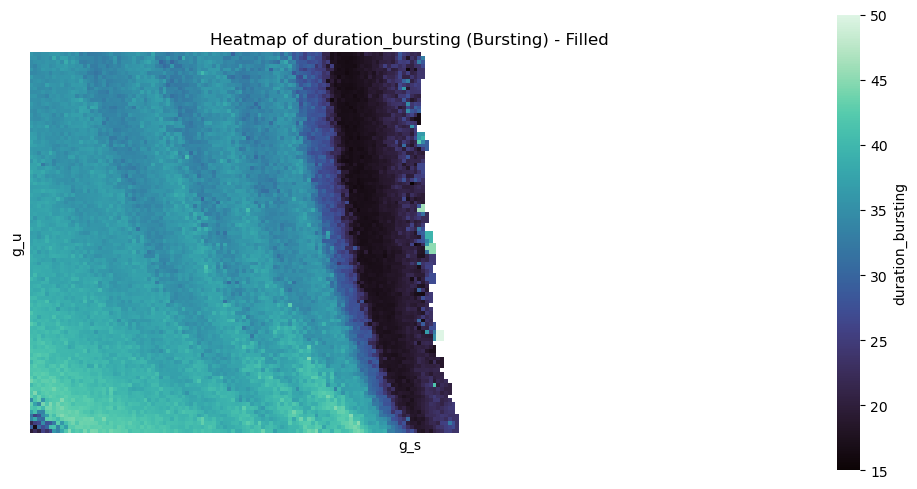

vmin: 2.0, vmax: 12.0


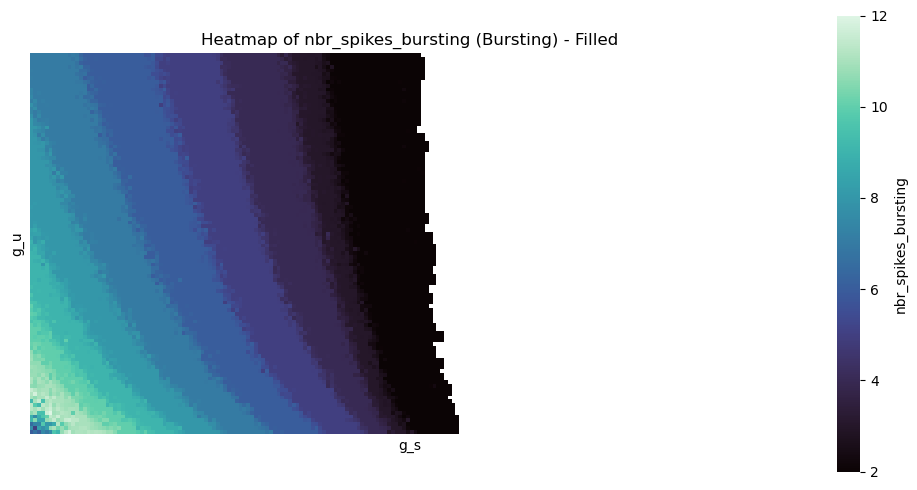

In [12]:
# == into heatmap 

binned_spiking_results = dspiking_results.copy()
binned_bursting_results = bursting_results.copy()

s = 5  # resolution multiplier
g_s_bin = pd.interval_range(start=-20, end=20, periods=40 * s, closed='left')
g_u_bin = pd.interval_range(start=0, end=20, periods=20 * s, closed='left')

# Apply binning
binned_spiking_results['g_s_bin'] = pd.cut(binned_spiking_results['g_s'], g_s_bin)
binned_spiking_results['g_u_bin'] = pd.cut(binned_spiking_results['g_u'], g_u_bin)

binned_bursting_results['g_s_bin'] = pd.cut(binned_bursting_results['g_s'], g_s_bin)
binned_bursting_results['g_u_bin'] = pd.cut(binned_bursting_results['g_u'], g_u_bin)

# Group means
binned_spiking_results_mean = binned_spiking_results.groupby(['g_s_bin', 'g_u_bin'])[features].mean().reset_index()
binned_bursting_results_mean = binned_bursting_results.groupby(['g_s_bin', 'g_u_bin'])[bursting_features].mean().reset_index()

# All bin combinations for full grid
full_grid = pd.MultiIndex.from_product([g_s_bin, g_u_bin], names=['g_s_bin', 'g_u_bin'])

f_spiking_v_min = 5
f_spiking_v_max = 20

bursting_v_min = [40, 3, 15, 2]
bursting_v_max = [300, 10, 50, 12]

# Fill missing values in spiking results
for feature in ['f_spiking']:
    df = binned_spiking_results_mean[['g_s_bin', 'g_u_bin', feature]].set_index(['g_s_bin', 'g_u_bin']).reindex(full_grid).reset_index()
    pivot = df.pivot(index='g_u_bin', columns='g_s_bin', values=feature)
    
    data_array = pivot.values
    mask = np.isnan(data_array)
    filtered_array = generic_filter(data_array, nanmean_filter, size=3, mode='constant', cval=np.nan)
    data_array[mask] = filtered_array[mask]
    #data_array[np.isnan(data_array)] = 0
    
    filled_spiking = pd.DataFrame(data_array, index=pivot.index, columns=pivot.columns)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(
        filled_spiking,
        cmap="mako",
        cbar_kws={"label": feature},
        square=True,
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        mask=np.isnan(data_array),  # Mask the NaN values
        linewidths=0,  # No lines between cells
        rasterized=True,
        vmin=f_spiking_v_min,
        vmax=f_spiking_v_max,
    )
    plt.title(f"Heatmap of {feature} (Spiking) - Filled")
    plt.xlabel("g_s")
    plt.ylabel("g_u")

    # print the vmin and vmax
    vmin = filled_spiking.min().min()
    vmax = filled_spiking.max().max()
    print(f"vmin: {vmin}, vmax: {vmax}")

    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.gca().invert_yaxis()
    plt.tight_layout()
    # save as svg
    plt.savefig(f"figures/heatmap_{feature}_spiking.svg", dpi=300)
    plt.show()

# Fill missing values in bursting results
i = 0
for feature in bursting_features:
    df = binned_bursting_results_mean[['g_s_bin', 'g_u_bin', feature]].set_index(['g_s_bin', 'g_u_bin']).reindex(full_grid).reset_index()
    pivot = df.pivot(index='g_u_bin', columns='g_s_bin', values=feature)
    
    data_array = pivot.values
    mask = np.isnan(data_array)
    filtered_array = generic_filter(data_array, nanmean_filter, size=3, mode='constant', cval=np.nan)
    data_array[mask] = filtered_array[mask]
    #data_array[np.isnan(data_array)] = 0
    
    filled_bursting = pd.DataFrame(data_array, index=pivot.index, columns=pivot.columns)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(
        filled_bursting,
        cmap="mako",
        cbar_kws={"label": feature},
        square=True,
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        mask=np.isnan(data_array),  # Mask the NaN values
        linewidths=0,  # No lines between cells
        rasterized=True,
        vmin=bursting_v_min[i],
        vmax=bursting_v_max[i],
    )
    i += 1
    plt.title(f"Heatmap of {feature} (Bursting) - Filled")
    plt.xlabel("g_s")
    plt.ylabel("g_u")
    ax = plt.gca()

    vmin = filled_bursting.min().min()
    vmax = filled_bursting.max().max()
    print(f"vmin: {vmin}, vmax: {vmax}")

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # save as svg
    plt.savefig(f"figures/heatmap_{feature}_bursting.svg", dpi=300)
    plt.show()
